In [1]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
df = pd.read_table('/project2/chihway/raulteixeira/data/deepfields.csv.gz', sep=',', header=0)

In [3]:
df

,ID,RA,DEC,KNN_CLASS,FLAGS,FLAGSTR,FLAGSTR_NIR,FLAGS_NIR,MASK_FLAGS,MASK_FLAGS_NIR,...,BDF_FLUX_DERED_CALIB_H,BDF_FLUX_DERED_CALIB_KS,BDF_FLUX_ERR_DERED_CALIB_U,BDF_FLUX_ERR_DERED_CALIB_G,BDF_FLUX_ERR_DERED_CALIB_R,BDF_FLUX_ERR_DERED_CALIB_I,BDF_FLUX_ERR_DERED_CALIB_Z,BDF_FLUX_ERR_DERED_CALIB_J,BDF_FLUX_ERR_DERED_CALIB_H,BDF_FLUX_ERR_DERED_CALIB_KS
0,692581195,52.901547,-28.866868,1.0,0,b'ok',b'ok',0,0,0,...,2203.376193,2728.724457,11.023836,4.354539,6.915013,10.472420,22.481337,32.829235,64.018955,46.272910
1,692581196,52.900143,-28.866868,1.0,0,b'ok',b'ok',0,0,0,...,1446.541056,1664.907561,11.348733,5.213569,7.697295,10.465219,21.190446,32.708205,76.518803,64.656877
2,692581197,52.919675,-28.867296,1.0,0,b'ok',b'ok',0,0,0,...,1360.572792,2012.706674,14.830872,6.298630,11.451556,16.559125,29.037093,38.015369,84.564620,56.049189
3,692581243,52.829388,-28.867336,1.0,0,b'ok',b'ok',0,0,0,...,97.346539,109.263756,10.986506,3.263357,4.673054,6.399380,16.439543,21.423243,41.629877,30.073837
4,692581244,52.775273,-28.867263,1.0,0,b'ok',b'ok',0,0,0,...,148.601450,730.181257,12.666281,4.314149,7.481621,10.854203,18.845930,82.181313,77.463570,197.384483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826983,698430493,36.867956,-4.961262,1.0,0,b'ok',b'ok',0,0,0,...,5266.005163,8166.625535,15.728777,4.798131,7.051887,13.929102,23.725032,17.626481,27.185082,38.591028
2826984,698430494,37.017461,-4.960645,1.0,0,b'ok',b'ok',0,0,0,...,175.089862,203.109568,16.844146,5.413177,6.719717,9.810262,16.686161,12.075323,18.595015,26.829536
2826985,698430540,36.775518,-4.960808,1.0,0,b'ok',b'ok',0,0,0,...,501.839842,297.926314,25.534359,8.097876,11.715031,16.273340,27.779018,22.047600,28.252853,35.188362
2826986,698430541,36.882046,-4.960811,1.0,0,b'ok',b'ok',0,0,0,...,83.336042,122.972020,14.204317,4.576144,5.665815,8.934449,15.384737,10.480140,17.402117,25.443768


In [13]:
# Open catalogs
#data_df = pd.read_csv('/project2/chihway/raulteixeira/data/deepfields.csv.gz')
specz = pd.read_table("/project2/chihway/delve_shear/BRPORTAL_E_6315_18670.csv", sep=',')

0 U
1 G


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


2 R
3 I
4 Z
5 J
6 H
7 KS


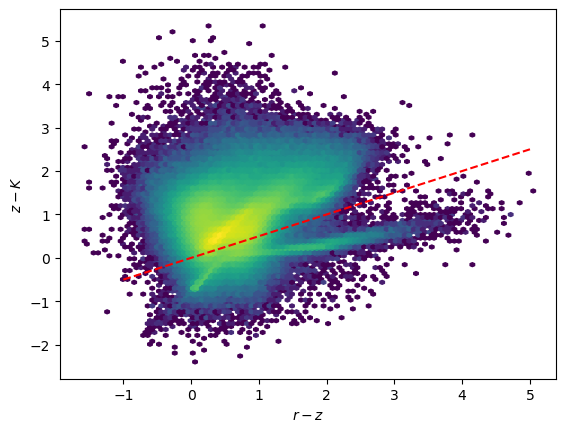

In [14]:
import pandas as pd
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30


df = pd.read_table('/project2/chihway/raulteixeira/data/deepfields.csv.gz', sep=',', header=0)


# Mask flagged regions
mask = df.MASK_FLAGS_NIR==0
mask &= df.MASK_FLAGS==0
mask &= df.FLAGS_NIR==0
mask &= df.FLAGS==0
mask &= df.FLAGSTR=="b'ok'"
mask &= df.FLAGSTR_NIR=="b'ok'"
df = df[mask]
df = df.drop(columns=[
    "MASK_FLAGS",
    "MASK_FLAGS_NIR",
    "FLAGS",
    "FLAGS_NIR",
    "FLAGSTR",
    "FLAGSTR_NIR",
])

deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
# remove crazy colors, defined as two 
# consecutive colors (e.g u-g, g-r, r-i, etc) 
# that have a value smaler than -1
mags_d = np.zeros((len(df),len(deep_bands_)))
magerrs_d = np.zeros((len(df),len(deep_bands_)))

for i,band in enumerate(deep_bands_):
    print(i,band)
    mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

colors = np.zeros((len(df),len(deep_bands_)-1))
for i in range(len(deep_bands_)-1):
    colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

normal_colors = np.mean(colors > -1, axis=1) == 1
normal_colors.sum()

df = df[normal_colors]

# mask faint objects, i < 25
df = df[flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25]

i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)


plt.hexbin((r-z), (z-k), gridsize=100, mincnt=1, bins='log')
_t = np.linspace(-1, 5, 100)
plt.plot(_t, 0.5*_t, color='r', ls='--')
plt.xlabel(r"$r-z$")
plt.ylabel(r"$z-K$")
plt.show()

# mask stars based on (z−K) > 0.5×(r −z) color cut

df = df[(z-k) > 0.5*(r-z)]

In [15]:
data_df = df

In [16]:
# Match spectra to DELVE catalog
spec_cd = SkyCoord(ra=specz['RA'].values*u.degree, dec=specz['DEC'].values*u.degree)
deep_cd = SkyCoord(ra=data_df['RA'].values*u.deg, dec=data_df['DEC'].values*u.deg)
idx, d2d, d3d = deep_cd.match_to_catalog_sky(spec_cd)
good_matches = d2d < 1.0*u.arcsec

print(len(np.unique(idx[good_matches])), np.count_nonzero(good_matches))

In [18]:
# Add spectra to DELVE catalog
data_df['zspec'] = np.nan
data_df.loc[good_matches, 'zspec'] = specz.iloc[idx[good_matches], specz.columns.get_loc('Z')].values

In [19]:
data_df.to_csv('/project2/chihway/raulteixeira/data/deepfields_specz.csv.gz')